In [1]:
import numpy as np
import matplotlib.pyplot as plt
from localization import datasets, models, samplers
import jax
import jax.numpy as jnp
from jax.scipy.special import erf as gain_function

In [2]:
config_ = dict(
  # data config
  num_dimensions=400,
  xi1=20,
  xi2=10,
  num_exemplars=1000,
  support=(-1, 1), # defunct
  class_proportion=0.5,
)

In [3]:
high_gain = datasets.NonlinearGPDataset(key=jax.random.PRNGKey(0), gain=3, **config_)
low_gain = datasets.NonlinearGPDataset(key=jax.random.PRNGKey(0), gain=0.01, **config_)

y_high = np.where(high_gain[:100][1])[0][0], np.where(1 - high_gain[:100][1])[0][0]
y_low = np.where(low_gain[:100][1])[0][0], np.where(1 - low_gain[:100][1])[0][0]

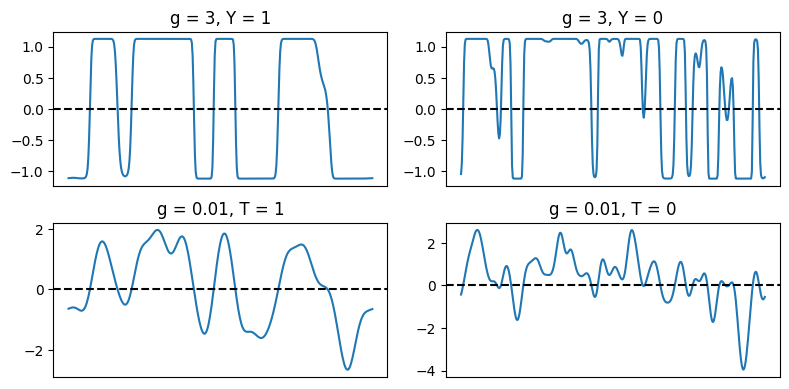

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(8, 4))
for i, ax in enumerate(axs.flatten()):
  if i // 2 == 0:
    ax.plot(high_gain[:100][0][y_high[i % 2]])
    ax.set_title(f"g = 3, Y = {y_high[i % 2]}")
  else:
    ax.plot(low_gain[:100][0][y_low[i % 2]])
    ax.set_title(f"g = 0.01, Y = {y_low[i % 2]}")
  ax.axhline(0, color='k', linestyle='--')
  ax.set_xticks([])
# fig.suptitle("Example data from the nonlinear GP dataset")
fig.tight_layout()
# fig.savefig("~/Doc*/Git*/Loc*/tho*/dist*/figs/samples_hd.png", dpi=300)
fig.savefig("samples_hd.png", dpi=300)

Already simulated


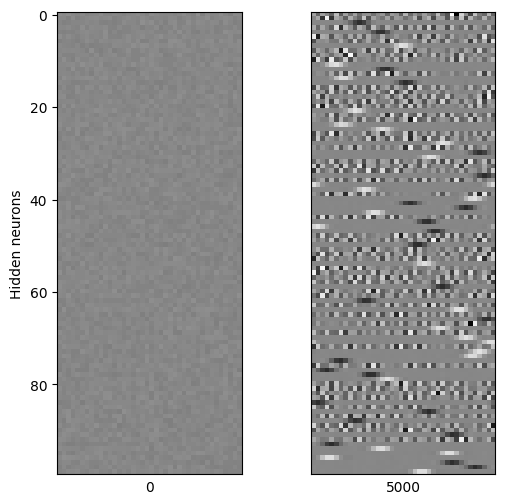

In [22]:
import optax
from localization import datasets, models, samplers
from localization.experiments import simulate_or_load
from localization.utils import plot_rf_evolution, plot_receptive_fields, entropy_sort, mean_sort, position_mean_var

config = dict(
  # data config
  num_dimensions=40,
  xi1=2,
  xi2=1,
  batch_size=1000,
  support=(-1, 1),
  class_proportion=0.5,
  # model config
  model_cls=models.SimpleNet,
  activation='sigmoid',
  num_hiddens=100,
  use_bias=True,
  sampler_cls=samplers.EpochSampler,
  init_fn=models.xavier_normal_init,
  init_scale=1,
  optimizer_fn=optax.sgd,
  learning_rate=50,
  num_epochs=5000,
  # experiment config
  seed=1,#0,
  save_=True,
  evaluation_interval=500,
)

weights_nlgp, metrics_nlgp = simulate_or_load(**config, gain=3, dataset_cls=datasets.NonlinearGPDataset)
# _ = plot_rf_evolution(weights_nlgp, figsize=(8, 4))
fig, axs = plot_receptive_fields(weights_nlgp[[0,-1]], evaluation_interval=5000, figsize=(6, 6), sort_fn=entropy_sort, ind=-1)

Text(0, 0.5, 'Hidden neuron index')

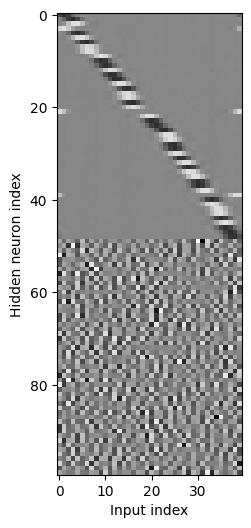

In [23]:
DFT = np.fft.fft(weights_nlgp[-1])
osc = weights_nlgp[-1][np.sum(np.sqrt(DFT.real ** 2 + DFT.imag ** 2), axis=1) > 150]
low = weights_nlgp[-1][np.sum(np.sqrt(DFT.real ** 2 + DFT.imag ** 2), axis=1) < 150]
low = low[np.argsort(position_mean_var(low)[0])]
rf = np.concatenate([low, osc], axis=0)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
im = ax.imshow(rf, cmap='gray')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xlabel("Input index")
ax.set_ylabel("Hidden neuron index")
# fig.savefig("localized_rf.png", dpi=300)
# fig.savefig("oscillatory_rf.png", dpi=300)

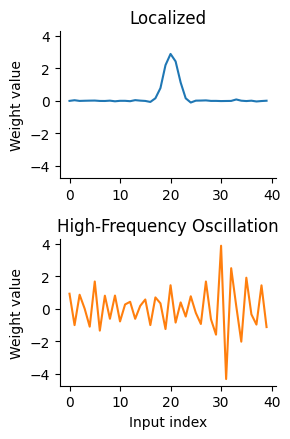

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3, 4.5), sharey=True)
# ax1.plot( low[11], label='Localized', color='tab:blue' )
ax1.plot( -low[23], label='Localized', color='tab:blue' )
ax2.plot( osc[0], label='Oscillatory', color='tab:orange' )
# ax1.set_title('Low-Frequency Oscillation')
ax1.set_title('Localized')
ax2.set_title('High-Frequency Oscillation')

for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.set_xticks([]); 
    # ax.set_yticks([])
ax1.set_ylabel("Weight value")
ax2.set_ylabel("Weight value")
ax2.set_xlabel("Input index")
    
fig.tight_layout()
fig.savefig("localized_oscillatory.png", dpi=300)
# fig.savefig("oscillatory_oscillatory.png", dpi=300)

(-3.0, 3.0)

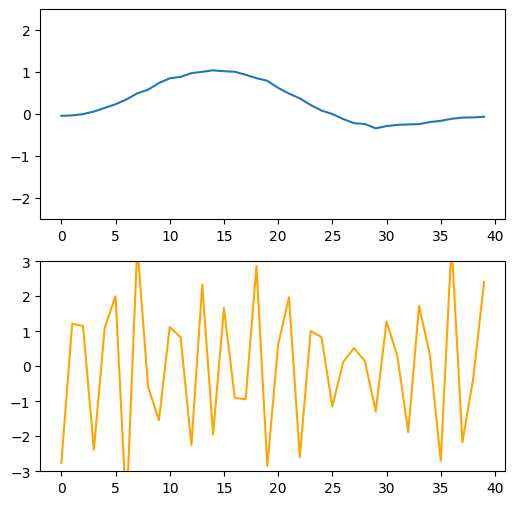

In [78]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
ax1.plot(low[11])
ax1.set_ylim(-2.5, 2.5)
ax2.plot(osc[5], color='orange')
ax2.set_ylim(-3, 3)

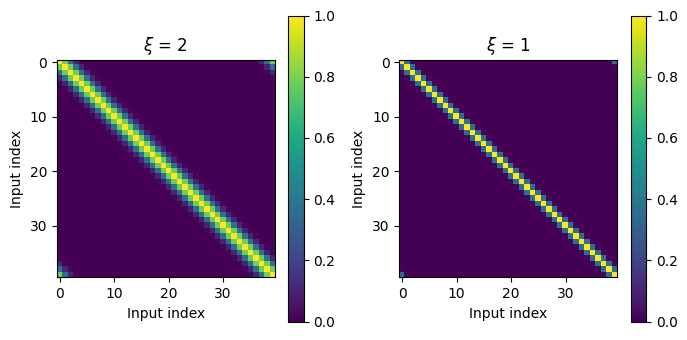

In [40]:
from localization.utils import build_gaussian_covariance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5))
im = ax1.imshow(build_gaussian_covariance(40, 2))
cbar = fig.colorbar(im, ax=ax1)
ax1.set_title(r"$\xi$ = 2")
ax1.set_xlabel("Input index"); ax1.set_ylabel("Input index")
ax1.set_xticks(np.arange(0, 40, 10)); ax1.set_yticks(np.arange(0, 40, 10))
im = ax2.imshow(build_gaussian_covariance(40, 1))
cbar = fig.colorbar(im, ax=ax2)
ax2.set_title(r'$\xi$ = 1')
ax2.set_xlabel("Input index"); ax2.set_ylabel("Input index")
ax2.set_xticks(np.arange(0, 40, 10)); ax2.set_yticks(np.arange(0, 40, 10))
fig.tight_layout()
fig.savefig("covariance.png", dpi=300)

In [32]:
np.sqrt(DFT.real ** 2 + DFT.imag ** 2)

array([[2.36670673e-02, 1.16934285e-02, 5.02774777e-02, ...,
        2.79809039e-02, 5.02774777e-02, 1.16934285e-02],
       [2.23654564e-02, 1.52094419e-02, 5.62208803e-02, ...,
        6.27726168e-02, 5.62208803e-02, 1.52094419e-02],
       [7.20960481e+00, 1.37529137e+01, 2.85437509e+00, ...,
        3.65572552e+00, 2.85437509e+00, 1.37529137e+01],
       ...,
       [1.55313073e+01, 1.04409081e+01, 2.63809383e+00, ...,
        6.83239841e-01, 2.63809383e+00, 1.04409081e+01],
       [1.08686644e+01, 1.28099251e+01, 4.09043713e+00, ...,
        5.66440413e-01, 4.09043713e+00, 1.28099251e+01],
       [1.38072507e+01, 9.52037692e+00, 7.18095440e+00, ...,
        1.65749041e+00, 7.18095440e+00, 9.52037692e+00]])